In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DATA

In [2]:
#@title Load Patches Dictionary
import numpy as np
import gc
import torch

embeddings = np.load('/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_bell_patches.npy', allow_pickle=True).item()

bell_files = []
bollinger_files = []
sick_files = []
long_files = []
lieberman_files = []

# Separate the embeddings based on the person's name
for key, (person, label, embedding, original_frames) in embeddings.items():
    embedding = embedding.view(10, -1)[-1]
    if person == 'bell':
        bell_files.append((embedding.float(), label, original_frames))
    elif person == 'sick':
        sick_files.append((embedding.float(), label, original_frames))
    elif person == 'long':
        long_files.append((embedding.float(), label, original_frames))
    elif person == 'bollinger':
        bollinger_files.append((embedding.float(), label, original_frames))
    elif person == 'lieberman':
        lieberman_files.append((embedding.float(), label, original_frames))

import gc

del embeddings
gc.collect()

print(f"Bell files: {len(bell_files)}")
print(f"Sick files: {len(sick_files)}")
print(f"Long files: {len(long_files)}")
print(f"Bollinger files: {len(bollinger_files)}")
print(f"Lieberman files: {len(lieberman_files)}")
print(f"TOT FILES: {len(bell_files)+len(sick_files)+len(long_files)+len(bollinger_files)+len(lieberman_files)}")

Bell files: 3751
Sick files: 3858
Long files: 2941
Bollinger files: 1539
Lieberman files: 1643
TOT FILES: 13732


In [ ]:
#@title Load Embedding Dictionary
import numpy as np
import gc
import torch

embeddings = np.load('/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_bollinger.npy', allow_pickle=True).item()

bell_files = []
bollinger_files = []
sick_files = []
long_files = []
lieberman_files = []

# Separate the embeddings based on the person's name
for key, (person, label, embedding, original_frames) in embeddings.items():
    if person == 'bell':
        bell_files.append((embedding.float(), label, original_frames))
    elif person == 'sick':
        sick_files.append((embedding.float(), label, original_frames))
    elif person == 'long':
        long_files.append((embedding.float(), label, original_frames))
    elif person == 'bollinger':
        bollinger_files.append((embedding.float(), label, original_frames))
    elif person == 'lieberman':
        lieberman_files.append((embedding.float(), label, original_frames))

import gc

del embeddings
gc.collect()

print(f"Bell files: {len(bell_files)}")
print(f"Sick files: {len(sick_files)}")
print(f"Long files: {len(long_files)}")
print(f"Bollinger files: {len(bollinger_files)}")
print(f"Lieberman files: {len(lieberman_files)}")
print(f"TOT FILES: {len(bell_files)+len(sick_files)+len(long_files)+len(bollinger_files)+len(lieberman_files)}")

Bell files: 3751
Sick files: 3858
Long files: 2941
Bollinger files: 1539
Lieberman files: 1643
TOT FILES: 13732


In [3]:
#@title Set Training Data
import torch
import numpy as np
from PIL import Image
import random

train_val_data = (
               #bell_files+
               sick_files+
               long_files+
               bollinger_files
               +lieberman_files
               )

In [4]:
#@title model for classification
import torch
from torch import nn
from torch.nn import functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        torch.manual_seed(0)
        self.fc1 = torch.nn.Linear(512, 64)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
#@title Set Seeds

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
#@title Custom Training con Validation
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

def custom_training(wandb_flag, learning_rate, weight_decay, batch_size, epochs, step_size=15, gamma=0.1):

  if wandb_flag:
    wandb.init(
      settings=wandb.Settings(console="off"),
      project="MLP Training ResNet Pretrained Embeddings",
      name="no bell grid-search",
      config={
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      'weight_decay': weight_decay}
    )

  set_seed(42)

  train_data, val_data = train_test_split(train_val_data, test_size=0.2)

  train_labels = [label for embedding, label, original_f in train_data]
  class_weights_train = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

  train_data_tensors = [(embedding.clone().detach(), torch.tensor(label)) for embedding, label, original_f in train_data]
  val_data_tensors = [(embedding.clone().detach(), torch.tensor(label)) for embedding, label, original_f in val_data]

  model = MyModel().cuda()
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
  criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights_train)[1].cuda())
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  for epoch in range(epochs):
      random.shuffle(train_data_tensors)
      correct_predictions = 0
      total_predictions = 0
      total_loss = 0
      for i in range(0, len(train_data_tensors), batch_size):
          batch = train_data_tensors[i:i+batch_size]
          X = torch.stack([embedding for embedding, label in batch]).cuda()
          y = torch.stack([label for embedding, label in batch]).cuda()

          optimizer.zero_grad()
          outputs = model(X.float()).squeeze()
          loss = criterion(outputs, y.float())
          loss.backward()

          probabilities = torch.sigmoid(outputs)
          predictions = (probabilities > 0.5).float()
          correct_predictions += (predictions == y).sum().item()
          total_predictions += y.size(0)
          total_loss += loss.item()

          optimizer.step()

      #scheduler.step()

      train_accuracy = correct_predictions / total_predictions
      train_loss = total_loss / total_predictions

      # Validation
      model.eval()  # set the model to evaluation mode
      with torch.no_grad():  # disable gradient calculation
          val_loss_total = 0
          num_batches = 0
          correct_predictions_val = 0
          total_predictions_val = 0
          all_predictions = []
          all_labels = []
          for i in range(0, len(val_data_tensors), batch_size):
              batch = val_data_tensors[i:i+batch_size]
              X_val = torch.stack([embedding for embedding, label in batch]).cuda()
              y_val = torch.stack([label for embedding, label in batch]).cuda()

              outputs_val = model(X_val.float()).squeeze()
              val_loss = criterion(outputs_val, y_val.float())
              val_loss_total += val_loss.item()
              num_batches += 1


              probabilities = torch.sigmoid(outputs_val)
              predictions_val = (probabilities > 0.5).float()
              all_predictions.extend(predictions_val.cpu().numpy())
              all_labels.extend(y_val.cpu().numpy())
              total_predictions_val += y_val.size(0)
              correct_predictions_val += (predictions_val == y_val).sum().item()

          val_loss = val_loss_total / total_predictions_val
          val_accuracy = correct_predictions_val / total_predictions_val
          f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
          f1_macro = f1_score(all_labels, all_predictions, average='macro')


      if wandb_flag:
        wandb.log({"Train loss": train_loss, "Train Accuracy": train_accuracy,
                "Val loss": val_loss, "Val Accuracy": val_accuracy,})

  if wandb_flag:  wandb.finish()
  return model, f1_macro, f1_weighted

In [ ]:
#@title K-CROSS VALIDATION
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random

model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])
criterion = torch.nn.BCEWithLogitsLoss()

k_folds = 5
# Define the KFold object
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_val_data)):
    print(f'-------------- FOLD {fold} ----------------')

    # Split the data into the current train and validation sets
    train_fold = [train_val_data[i] for i in train_ids]
    val_fold = [train_val_data[i] for i in val_ids]
    train_data_tensors = [(embedding.clone().detach(), torch.tensor(label)) for embedding, label, original_f in train_fold]
    val_data_tensors = [(embedding.clone().detach(), torch.tensor(label)) for embedding, label, original_f in val_fold]

    cum_fold_val_loss = 0
    cum_fold_val_accuracy = 0
    cum_fold_train_loss = 0
    cum_fold_train_accuracy = 0

    # Initialize your model and optimizer for each fold
    model = MyModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'], weight_decay = args['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    batch_size = args['batch_size']
    for epoch in range(args['epochs']):

        random.shuffle(train_data_tensors)
        # Training
        model.train()
        correct_predictions = 0
        total_predictions = 0
        total_loss = 0
        for i in range(0, len(train_data_tensors), args["batch_size"]):
            batch = train_data_tensors[i:i+args["batch_size"]]
            X = torch.stack([embedding for embedding, label in batch]).cuda()
            y = torch.stack([label for embedding, label in batch]).cuda()

            optimizer.zero_grad()
            outputs = model(X.float()).squeeze()
            loss = criterion(outputs, y.float())
            loss.backward()

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            correct_predictions += (predictions == y).sum().item()
            total_predictions += y.size(0)
            total_loss += loss.item()

            optimizer.step()

        scheduler.step()

        train_accuracy = correct_predictions / total_predictions
        train_loss = total_loss / total_predictions

        cum_fold_train_loss += train_loss
        cum_fold_train_accuracy += train_accuracy

        # Validation
        model.eval()  # set the model to evaluation mode
        with torch.no_grad():  # disable gradient calculation
            val_loss_total = 0
            num_batches = 0
            correct_predictions_val = 0
            total_predictions_val = 0
            all_predictions = []
            all_labels = []
            for i in range(0, len(val_data_tensors), args["batch_size"]):
                batch = val_data_tensors[i:i+args["batch_size"]]
                X_val = torch.stack([embedding for embedding, label in batch]).cuda()
                y_val = torch.stack([label for embedding, label in batch]).cuda()

                outputs_val = model(X_val.float()).squeeze()
                val_loss = criterion(outputs_val, y_val.float())
                val_loss_total += val_loss.item()
                num_batches += 1


                probabilities = torch.sigmoid(outputs_val)
                predictions_val = (probabilities > 0.5).float()
                all_predictions.extend(predictions_val.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())
                total_predictions_val += y_val.size(0)
                correct_predictions_val += (predictions_val == y_val).sum().item()

            val_loss = val_loss_total / total_predictions_val
            val_accuracy = correct_predictions_val / total_predictions_val

            cum_fold_val_loss += val_loss
            cum_fold_val_accuracy += val_accuracy

        # print(f"Epoch {epoch}:\n\tTrain loss: {round(train_loss,4)}\tTrain accuracy: {round(train_accuracy,4)}")
        # print(f"\tVal loss: {round(val_loss,4)}\tVal accuracy:{round(val_accuracy,4)}")

    avg_fold_val_loss = cum_fold_val_loss / args['epochs']
    avg_fold_val_accuracy = cum_fold_val_accuracy / args['epochs']
    avg_fold_train_loss = cum_fold_train_loss / args['epochs']
    avg_fold_train_accuracy = cum_fold_train_accuracy / args['epochs']

    print(f"   Average Train Loss:\t\t {round(avg_fold_train_loss,4)}  \tAverage Train Accuracy:\t\t {round(avg_fold_train_accuracy,4)}")
    print(f"   Average Validation Loss:\t {round(avg_fold_val_loss,4)}  \tAverage Validation Accuracy:\t {round(avg_fold_val_accuracy,4)}")
    if wandb_flag:
      wandb.log({"Fold Validation loss": avg_fold_val_loss, "Fold Validation Accuracy": avg_fold_val_accuracy, "Fold Train loss": avg_fold_train_loss, "Fold Train accuracy":avg_fold_train_accuracy})

if wandb_flag: wandb.finish()


In [ ]:
#@title GRID SEARCH
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    # 'step_size': [5, 15, 25],
    # 'gamma': [0.1, 0.01, 0.001]
}

# Create the parameter grid
grid = ParameterGrid(param_grid)

best_val_acc = 0
best_params = None

for num, params in enumerate(grid):
  _, train_loss, train_acc, val_loss, val_acc = custom_training(wandb_flag = False, **params)
  #print(f"---- RUN {num} ----\n >Train Loss: {round(train_loss,4)}\tTrain Acc: {round(train_acc,4)}\tVal Loss: {round(val_loss,4)}\t Val Acc: {round(val_acc,4)}")
  if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_params = params

print(f'Best validation accuracy: {best_val_acc}')
print(f'Best parameters: {best_params}')

Best validation accuracy: 0.998359983599836
Best parameters: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'weight_decay': 0.001}


In [7]:
#@title RANDOM SEARCH
from sklearn.model_selection import ParameterSampler
import numpy as np

# 17 min per search
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30],
}


# Create the parameter grid
n_iter_search = 22  # Number of parameter settings that are sampled.
random_search = ParameterSampler(param_grid, n_iter=n_iter_search, random_state=0)

best_macro = 0
best_weighted = 0
best_macro_params = None
best_weight_params = None

for num, params in enumerate(random_search):
  print(f"--- {num} ---")
  model, macro, weighted  = custom_training(False, **params)
  if macro > best_macro:
      best_macro = macro
      best_macro_params = params
      print(f"Found new best F1 MACRO: {macro} \t {params}")
  if weighted > best_weighted:
      best_weighted = weighted
      best_weight_params = params
      print(f"Found new best F1 WEIGHTED: {weighted} \t {params}")

print(f'\nbest F1 WEIGHTED: {best_weighted} with parameters: {best_weight_params}')
print(f'Found new best F1 MACRO: {best_macro} with parameters: {best_macro_params}')

--- 0 ---
Found new best F1 MACRO: 0.9967760579114926 	 {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}
Found new best F1 WEIGHTED: 0.9969963356019649 	 {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}
--- 1 ---
--- 2 ---
--- 3 ---
--- 4 ---
--- 5 ---
--- 6 ---
--- 7 ---
--- 8 ---
--- 9 ---
--- 10 ---
--- 11 ---
--- 12 ---
--- 13 ---
--- 14 ---
--- 15 ---
--- 16 ---
Found new best F1 MACRO: 0.9967778612011677 	 {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 64}
Found new best F1 WEIGHTED: 0.9969971705580772 	 {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 64}
--- 17 ---
--- 18 ---
--- 19 ---
--- 20 ---
--- 21 ---

best F1 WEIGHTED: 0.9969971705580772 with parameters: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 64}
Found new best F1 MACRO: 0.9967778612011677 with parameters: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 20, 

In [8]:
#best_macro_params =  {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 20, 'batch_size': 16}
model, _,_ = custom_training(wandb_flag = False, **best_macro_params)

## TESTING

In [9]:
test_data_tensors = [(embedding.clone().detach(), torch.tensor(label), torch.tensor(original_frames))
                    for embedding, label, original_frames in bell_files]

In [10]:
#@title Test Code
from sklearn.metrics import f1_score

criterion = torch.nn.BCEWithLogitsLoss()

model.eval()

with torch.no_grad():
    test_loss_total = 0
    tot = 0
    correct_predictions_test = 0
    total_predictions_test = 0
    all_predictions = []
    all_labels = []
    for i in range(0, len(test_data_tensors)):
        embedding, y_test, original_frames = test_data_tensors[i]
        X_test = embedding.unsqueeze(0).cuda()  # Add a batch dimension
        y_test = y_test.cuda()

        outputs_test = model(X_test.float()).squeeze()
        test_loss = criterion(outputs_test, y_test.float())
        test_loss_total += test_loss.item()
        tot += 1

        outputs_prob = torch.sigmoid(outputs_test)
        prediction_test = (outputs_prob > 0.5).float().cpu()  # prediction for each embedding

        all_predictions.extend([prediction_test] * original_frames.item())
        all_labels.extend([y_test.item()] * original_frames.item())
        total_predictions_test += original_frames.item()
        correct_predictions_test += (prediction_test == y_test.item()) * original_frames.item()

    test_accuracy = (correct_predictions_test / total_predictions_test).item()
    test_loss = test_loss_total / tot
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

print(f"TOT PREDICTIONS: {total_predictions_test}")
print("Test loss: ", round(test_loss,4))
print("Test Accuracy: ", round(test_accuracy,4))
print("F1 Weighted: ", round(f1_weighted,4))
print("F1 Macro: ", round(f1_macro,4))

TOT PREDICTIONS: 37422
Test loss:  0.2286
Test Accuracy:  0.9076
F1 Weighted:  0.9076
F1 Macro:  0.9075


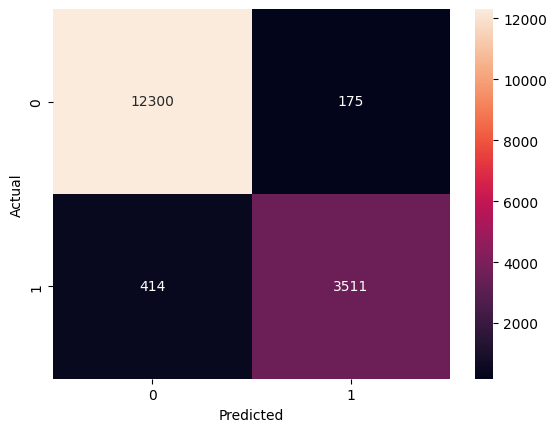

In [ ]:
#@title CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert all_predictions and all_labels to numpy arrays if they aren't already
all_predictions_np = np.array(all_predictions)
all_labels_np = np.array(all_labels)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_np, all_predictions_np)

# Assuming cm is your confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# [[TN FP]
#  [FN TP]]

In [ ]:
# INITIALIZE FINAL MATRIX
final_cm = np.zeros((2, 2), dtype=int)  # Assuming binary classification

In [ ]:
final_cm+=cm

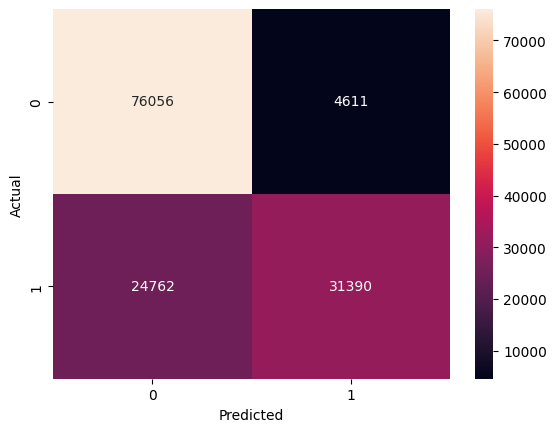

In [ ]:
sns.heatmap(final_cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#@title Pretrained ViT-B/16 using F1 Macro/Weighted for best params
# ----------------  -----------------------
# Bell
# Test loss:  0.9649
# Test Accuracy:  0.6875
# F1 Weighted:  0.6629
# F1 Macro:  0.6653
# Params: {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 20, 'batch_size': 16}

# Sick
# Test loss:  0.2019
# Test Accuracy:  0.9197
# F1 Weighted:  0.9203
# F1 Macro:  0.9159
# Params: {'weight_decay': 0.01, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 32}

# Long
# Test loss:  2.059
# Test Accuracy:  0.6059
# F1 Weighted:  0.4902
# F1 Macro:  0.4494
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 32}

# Bollinger
# Test loss:  0.4112
# Test Accuracy:  0.8399
# F1 Weighted:  0.8419
# F1 Macro:  0.836
# Params: {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 20, 'batch_size': 16}

# Lieberman
# Test loss:  0.0983
# Test Accuracy:  0.9641
# F1 Weighted:  0.9637
# F1 Macro:  0.9496
# Params: {'weight_decay': 0.001, 'learning_rate': 0.0001, 'epochs': 20, 'batch_size': 16}

In [ ]:
#@title Pretrained ResNet using F1 Macro/Weighted for best params
# ----------------  -----------------------
# Bell:
# Test loss:  1.3966
# Test Accuracy:  0.6973
# F1 Weighted:  0.6705
# F1 Macro:  0.6677
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 32}

# Sick:
# Test loss:  0.569
# Test Accuracy:  0.8513
# F1 Weighted:  0.8535
# F1 Macro:  0.8499
# Params: {'weight_decay': 0.001, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 64}

# Long:
# Test loss:  0.7018
# Test Accuracy:  0.853
# F1 Weighted:  0.8466
# F1 Macro:  0.8403
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 16}

# Bollinger
# Test loss:  0.4689
# Test Accuracy:  0.8554
# F1 Weighted:  0.8573
# F1 Macro:  0.8525
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}

# Lieberman:
# Test loss:  0.1257
# Test Accuracy:  0.9596
# F1 Weighted:  0.9586
# F1 Macro:  0.9419
# Params: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}

In [ ]:
#@title Finetuned ResNet using F1 Macro/Weighted for best params

# Bell:
# Test loss:  0.2286
# Test Accuracy:  0.9076
# F1 Weighted:  0.9076
# F1 Macro:  0.9075
# Params: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 20, 'batch_size': 64}

# Sick:
# Test loss:  0.113
# Test Accuracy:  0.9641
# F1 Weighted:  0.9637
# F1 Macro:  0.961
# parameters: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}

# Long:
# Test loss:  0.4941
# Test Accuracy:  0.8142
# F1 Weighted:  0.814
# F1 Macro:  0.8142
# parameters: {'weight_decay': 0.01, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 64}

# Bollinger:
# Test loss:  0.5795
# Test Accuracy:  0.7446
# F1 Weighted:  0.7346
# F1 Macro:  0.7123
# parameters: {'weight_decay': 0.0001, 'learning_rate': 0.0001, 'epochs': 30, 'batch_size': 64}

# Lieberman:
# Test loss:  0.1162
# Test Accuracy:  0.9741
# F1 Weighted:  0.9744
# F1 Macro:  0.9652
# parameters: {'weight_decay': 0.001, 'learning_rate': 0.01, 'epochs': 30, 'batch_size': 32}

## T-SNE

In [ ]:
emb_pretrained = []
for b in bell_files:
  emb_pretrained.append(b[0])

In [ ]:
emb_finetuned = []
for b in bell_files:
  emb_finetuned.append(b[0])

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming `embeddings_pretrained` and `embeddings_finetuned` are your collections of embeddings
embeddings_pretrained_np = torch.stack(emb_pretrained[:2800]).cpu().numpy()
embeddings_finetuned_np = torch.stack(emb_finetuned[:2800]).cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)  # Initialize t-SNE
embeddings_pretrained_2d = tsne.fit_transform(embeddings_pretrained_np)  # Apply t-SNE to pre-trained embeddings
embeddings_finetuned_2d = tsne.fit_transform(embeddings_finetuned_np)  # Apply t-SNE to fine-tuned embeddings

# Plot
plt.scatter(embeddings_pretrained_2d[:, 0], embeddings_pretrained_2d[:, 1], color='b', label='Pre-trained')
plt.scatter(embeddings_finetuned_2d[:, 0], embeddings_finetuned_2d[:, 1], color='r', label='Fine-tuned')
plt.legend()
plt.show()
